# Test 3 with Optuna optimization

In [1]:
%load_ext autoreload
%autoreload
from test3 import *

TEST_ID = 3
COST = Cost3
MODEL = Model3()

import optuna
optuna.logging.set_verbosity(optuna.logging.WARNING) # Limit the verbosity of Optuna

## 1. HillClimbing Radar

Best parameters: {'num_samples': 8, 'patience': 925, 'static_perturbation_factor': 0.4905216565085807, 'dynamic_perturbation_factor': 4.8276060814524655, 'inflation_vector_max_perturbation': 30.52501911585299}
Best score: 0.9999869558438753


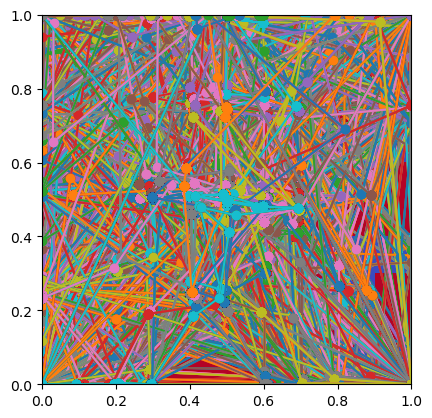

In [138]:
number_of_tests = 3 # repeat each configuration 3 times and take mean values

def objective(trial):
    # Define the parameter search space for Optuna
    num_samples = trial.suggest_int("num_samples", 1, 10)
    patience = trial.suggest_int("patience", 1, 1000)
    static_perturbation_factor = trial.suggest_float("static_perturbation_factor", 1e-6, 10)
    dynamic_perturbation_factor = trial.suggest_float("dynamic_perturbation_factor", 1.0, 10.0)
    inflation_vector_max_perturbation = trial.suggest_float("inflation_vector_max_perturbation", 1.0, 100.0)

    # Initialize the attack
    attack = HillClimbing(estimator=MODEL, verbose=0)
    neighborhood = Radar(constraints)
    
    # Try running the test with selected parameters
    try:
        score = list()
        queries = list()
        for _ in range(number_of_tests):
            _, s, _, q = run_test(
                test_id=TEST_ID,
                verbose=False,
                show_graph=False,
                save_graph=False,
                num_samples=num_samples,
                attack=attack,
                neighborhood=neighborhood,
                targeted=True,
                specific_class=0,
                patience=patience,
                cost_function=COST,
                static_perturbation_factor=static_perturbation_factor,
                dynamic_perturbation_factor=dynamic_perturbation_factor,
                enable_negative_inflation_vector=True,
                inflation_vector_max_perturbation=inflation_vector_max_perturbation
            )
            score.append(s)
            queries.append(q)
        sc = np.mean(score)
        total_queries = np.mean(queries)
    except Exception as e:
        return float("inf")  # Return high value if an error occurs

    # If the score is 100%, we then would like to minimize number of queries.
    if sc >= 1.0:
        sc -= total_queries
    return 1 - sc  # Objective to minimize

# Create and run the study
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=200)

# Print the best parameters and result
print("Best parameters:", study.best_params)
print("Best score:", 1 - study.best_value)

In [139]:
optuna.importance.get_param_importances(study)

{'static_perturbation_factor': 0.5135994481127715,
 'patience': 0.23422404904329006,
 'num_samples': 0.20208836501827582,
 'inflation_vector_max_perturbation': 0.04137678359992238,
 'dynamic_perturbation_factor': 0.008711354225740158}

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Score: 0.9994039422025734
Total time: 1.6849994659423828
Number of queries: 4481


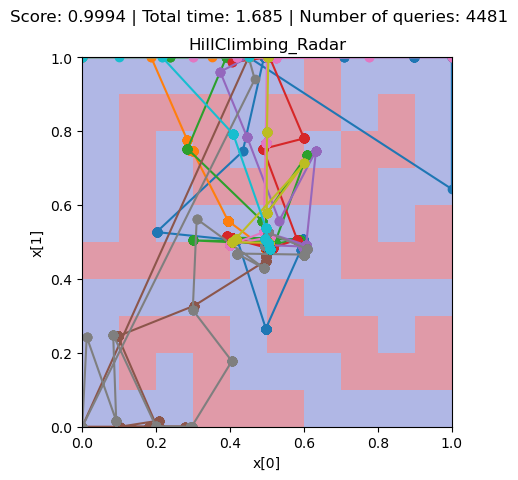

Final run results:
Score: 0.9994039422025734
Total time: 1.6849994659423828
Total queries: 4481


In [11]:
# Retrieve the best parameters from the Optuna study
best_params = study.best_params

# Run the test with verbose output and graph options enabled
_, score, total_time, total_queries = run_test(
    test_id=TEST_ID,
    verbose=True,
    show_graph=True,
    save_graph=True,
    num_samples=best_params["num_samples"],
    attack=HillClimbing(estimator=MODEL, verbose=1),
    neighborhood=Radar(constraints),
    targeted=True,
    specific_class=0,
    patience=best_params["patience"],
    cost_function=COST,
    static_perturbation_factor=best_params["static_perturbation_factor"],
    dynamic_perturbation_factor=best_params["dynamic_perturbation_factor"],
    enable_negative_inflation_vector=True,
    inflation_vector_max_perturbation=best_params["inflation_vector_max_perturbation"]
)

# Display results
print("Final run results:")
print("Score:", score)
print("Total time:", total_time)
print("Total queries:", total_queries)

## 2. SimulatedAnnealing Radar

Score: 0.6528633498629148
Total time: 25.52823519706726
Number of queries: 832681


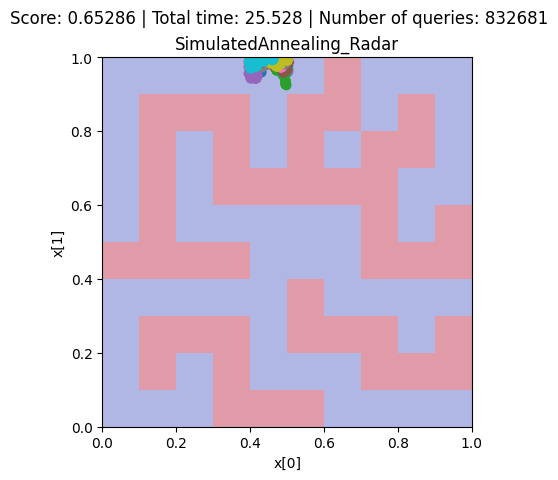

(np.float64(2.2323351079866525),
 np.float64(0.6528633498629148),
 25.52823519706726,
 832681)

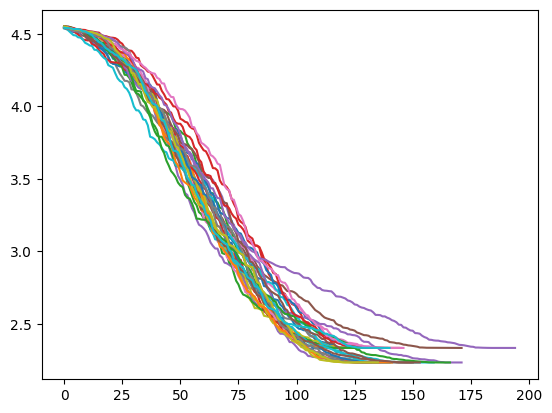

In [66]:
%autoreload 2
run_test(attack=SimulatedAnnealing(estimator=MODEL, verbose=0), name="SimulatedAnnealing_Radar", plot_history=True,
          num_samples=30, patience=10000, static_perturbation_factor=0.001, dynamic_perturbation_factor=1.5,
          cooling_rate=0.999, initial_temperature=1000, inflation_vector_max_perturbation=10,
          enable_negative_inflation_vector=False)

Best parameters: {'static_perturbation_factor': 1.1545726485874728, 'dynamic_perturbation_factor': 3.3086190885573092, 'patience': 699, 'initial_temperature': 8641.351611704287, 'final_temperature': 0.17488894098270777, 'cooling_rate': 0.6672717612305922, 'inflation_vector_max_perturbation': 80.65709655595519}
Best score: 0.8852099899444344


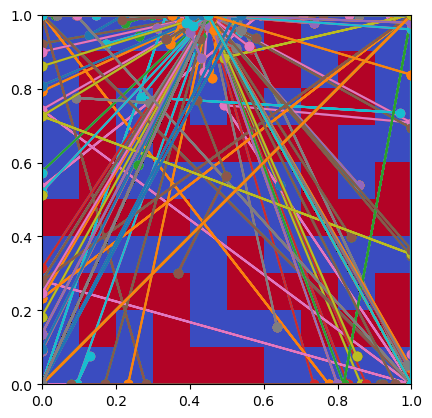

In [140]:
number_of_tests = 3 # repeat each configuration n times and take mean values

def objective(trial):
    # Define the parameter search space for Optuna
    static_perturbation_factor = trial.suggest_float(
        "static_perturbation_factor", 1e-8, 100, log=False
    )
    dynamic_perturbation_factor = trial.suggest_float(
        "dynamic_perturbation_factor", 1.0, 5.0
    )
    patience = trial.suggest_int("patience", 1, 1000)
    initial_temperature = trial.suggest_float(
        "initial_temperature", 1.0, 10000.0, log=False
    )
    final_temperature = trial.suggest_float(
        "final_temperature", 1e-12, 0.99, log=False
    )
    cooling_rate = trial.suggest_float("cooling_rate", 0.50, 0.999)
    inflation_vector_max_perturbation = trial.suggest_float(
        "inflation_vector_max_perturbation", 1.0, 100.0
    )

    # Initialize the attack
    attack = SimulatedAnnealing(estimator=MODEL, verbose=0)
    neighborhood = Radar(constraints)
    
    # Try running the test with selected parameters
    try:
        score = list()
        queries = list()
        for _ in range(number_of_tests):
            _, s, _, q = run_test(
                test_id=TEST_ID,
                name="SimulatedAnnealing_Radar",
                verbose=False,
                show_graph=False,
                save_graph=False,
                num_samples=3,
                attack=attack,
                neighborhood=neighborhood,
                targeted=True,
                specific_class=0,
                patience=patience,
                cost_function=COST,
                static_perturbation_factor=static_perturbation_factor,
                dynamic_perturbation_factor=dynamic_perturbation_factor,
                enable_negative_inflation_vector=True,
                inflation_vector_max_perturbation=inflation_vector_max_perturbation,
                
                initial_temperature=initial_temperature,
                final_temperature=final_temperature,
                cooling_rate=cooling_rate,
            )
            score.append(s)
            queries.append(q)
        sc = np.mean(score)
        total_queries = np.mean(queries)
    
    except Exception as e:
        return float("inf")  # Return a high value if an error occurs

    # If the score is 100%, we then would like to minimize number of queries.
    if sc >= 1.0:
        sc -= total_queries
    return 1 - sc  # Objective to minimize

# Create and run the study
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=200)

# Print the best parameters and result
print("Best parameters:", study.best_params)
print("Best score:", 1 - study.best_value)

In [141]:
optuna.importance.get_param_importances(study)

{'static_perturbation_factor': 0.7449019050165876,
 'inflation_vector_max_perturbation': 0.11534133822217713,
 'initial_temperature': 0.07436588695374975,
 'final_temperature': 0.06046264491183216,
 'dynamic_perturbation_factor': 0.0021740364981894605,
 'cooling_rate': 0.0015339745328528413,
 'patience': 0.001220213864611057}

Score: 0.9605876056293374
Total time: 0.17900943756103516
Number of queries: 1520


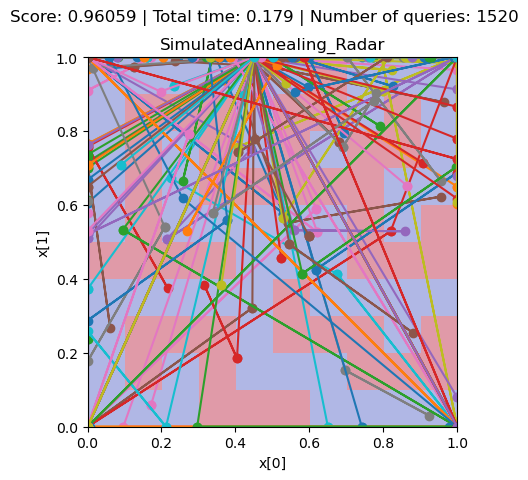

Final run results:
Score: 0.9605876056293374
Total time: 0.17900943756103516
Total queries: 1520


In [137]:
# Retrieve the best parameters from the Optuna study
best_params = study.best_params

# Run the test with verbose output and graph options enabled
_, score, total_time, total_queries = run_test(
    test_id=TEST_ID,
    name="SimulatedAnnealing_Radar",
    verbose=True,
    show_graph=True,
    save_graph=True,
    num_samples=200,
    attack=SimulatedAnnealing(estimator=MODEL, verbose=0),
    neighborhood=Radar(constraints),
    targeted=True,
    specific_class=0,
    patience=best_params["patience"],
    cost_function=COST,
    static_perturbation_factor=best_params["static_perturbation_factor"],
    dynamic_perturbation_factor=best_params["dynamic_perturbation_factor"],
    enable_negative_inflation_vector=True,
    inflation_vector_max_perturbation=best_params["inflation_vector_max_perturbation"],
    
    initial_temperature=best_params["initial_temperature"],
    final_temperature=best_params["final_temperature"],
    cooling_rate=best_params["cooling_rate"],
)

# Display results
print("Final run results:")
print("Score:", score)
print("Total time:", total_time)
print("Total queries:", total_queries)

# 3. TabuSeach Radar

Score: 0.5459385040917406
Total time: 2.6179003715515137
Number of queries: 8006


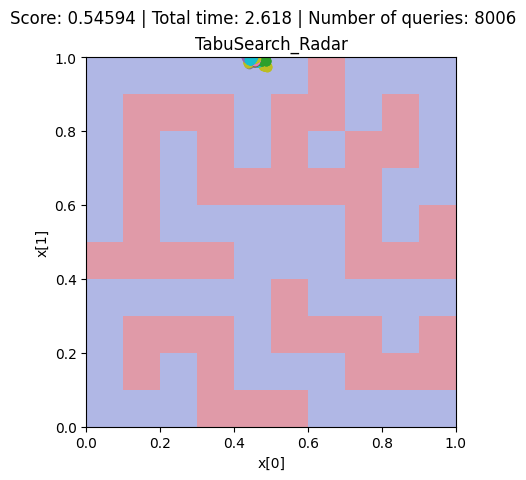

(np.float64(2.6119183104743207),
 np.float64(0.5459385040917406),
 2.6179003715515137,
 8006)

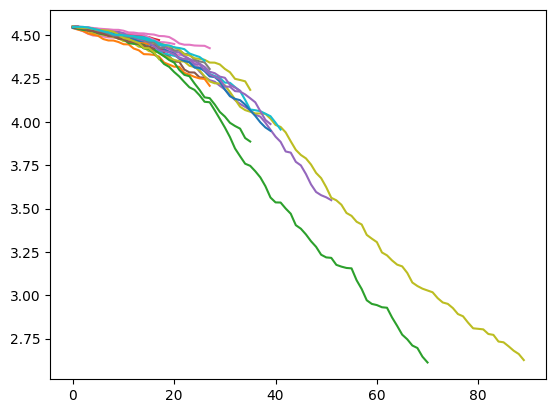

In [65]:
run_test(attack=TabuSearch(estimator=MODEL, verbose=0), name="TabuSearch_Radar", num_samples=30, plot_history=True,
         static_perturbation_factor=0.001, dynamic_perturbation_factor=1.5, tabu_tenure=100)

C:\Users\allem\OneDrive - Université Libre de Bruxelles\MA2-IRIFS\Q1\MEMOIRE\Thesis - Temp repository\neighborhoods\Radar.py:162: RuntimeWarning: overflow encountered in double_scalars
  perturbation_weights = [perturbation_weights[i] * dynamic_perturbation_factor * sigmoid(inflation_vector[i]) for i in range(len(x))]


Best parameters: {'static_perturbation_factor': 0.5673586637729409, 'dynamic_perturbation_factor': 4.290408430055025, 'patience': 754, 'tabu_tenure': 45, 'max_tabu_size': 50, 'similarity_epsilon': 6.3265385663600015e-06, 'inflation_vector_max_perturbation': 79.54031181207617}
Best score: 0.9990798843389209


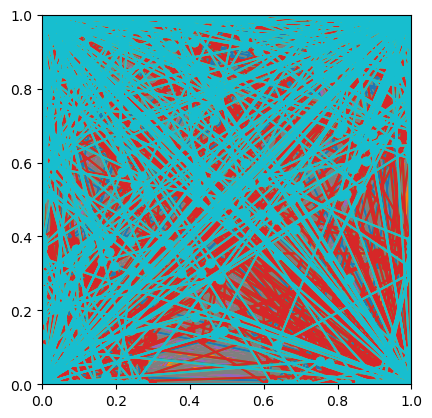

In [142]:
number_of_tests = 3 # repeat each configuration n times and take mean values

def objective(trial):
    # Define the parameter search space for Optuna
    static_perturbation_factor = trial.suggest_float(
        "static_perturbation_factor", 1e-8, 100, log=True
    )
    dynamic_perturbation_factor = trial.suggest_float(
        "dynamic_perturbation_factor", 1.0, 5.0
    )
    patience = trial.suggest_int("patience", 1, 1000)
    tabu_tenure = trial.suggest_int("tabu_tenure", 5, 50)
    max_tabu_size = trial.suggest_int("max_tabu_size", 50, 500)
    similarity_epsilon = trial.suggest_float(
        "similarity_epsilon", 1e-8, 1, log=True
    )
    
    inflation_vector_max_perturbation = trial.suggest_float(
        "inflation_vector_max_perturbation", 1.0, 100.0
    )

    # Initialize the attack
    attack = TabuSearch(estimator=MODEL, verbose=0)
    neighborhood = Radar(constraints)
    
    # Try running the test with selected parameters
    try:
        score = list()
        queries = list()
        for _ in range(number_of_tests):
            _, s, _, q = run_test(
                test_id=TEST_ID,
                name="TabuSearch_Radar",
                verbose=False,
                show_graph=False,
                save_graph=False,
                num_samples=1,
                attack=attack,
                neighborhood=neighborhood,
                targeted=True,
                specific_class=0,
                patience=patience,
                cost_function=COST,
                static_perturbation_factor=static_perturbation_factor,
                dynamic_perturbation_factor=dynamic_perturbation_factor,
                enable_negative_inflation_vector=True,
                inflation_vector_max_perturbation=inflation_vector_max_perturbation,
                
                tabu_tenure=tabu_tenure,
                max_tabu_size=max_tabu_size,
                similarity_epsilon=similarity_epsilon,
            )
            score.append(s)
            queries.append(q)
        sc = np.mean(score)
        total_queries = np.mean(queries)
    
    except Exception as e:
        return float("inf")  # Return a high value if an error occurs

    # If the score is 100%, we then would like to minimize number of queries.
    if sc >= 1.0:
        sc -= total_queries
    return 1 - sc  # Objective to minimize

# Create and run the study
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=200)

# Print the best parameters and result
print("Best parameters:", study.best_params)
print("Best score:", 1 - study.best_value)

In [143]:
optuna.importance.get_param_importances(study)

{'static_perturbation_factor': 0.7613219956006552,
 'patience': 0.17718849620264857,
 'inflation_vector_max_perturbation': 0.023364750948882237,
 'tabu_tenure': 0.019110255907320874,
 'max_tabu_size': 0.012470460289230814,
 'dynamic_perturbation_factor': 0.006541894753519505,
 'similarity_epsilon': 2.146297742896046e-06}

  0%|          | 0/100000 [00:00<?, ?it/s]

Score: 0.970006826385502
Total time: 0.17699837684631348
Number of queries: 2271


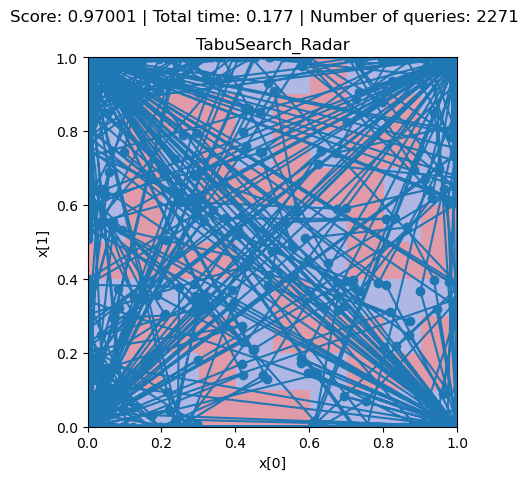

Final run results:
Score: 0.970006826385502
Total time: 0.17699837684631348
Total queries: 2271


In [107]:
# Retrieve the best parameters from the Optuna study
best_params = study.best_params

# Run the test with verbose output and graph options enabled
_, score, total_time, total_queries = run_test(
    test_id=TEST_ID,
    name="TabuSearch_Radar",
    verbose=True,
    show_graph=True,
    save_graph=True,
    num_samples=1,
    attack=TabuSearch(estimator=MODEL, verbose=1),
    neighborhood=Radar(constraints),
    targeted=True,
    specific_class=0,
    patience=best_params["patience"],
    cost_function=COST,
    static_perturbation_factor=best_params["static_perturbation_factor"],
    dynamic_perturbation_factor=best_params["dynamic_perturbation_factor"],
    enable_negative_inflation_vector=True,
    inflation_vector_max_perturbation=best_params["inflation_vector_max_perturbation"],
    
    tabu_tenure=best_params["tabu_tenure"],
    max_tabu_size=best_params["max_tabu_size"],
    similarity_epsilon=best_params["similarity_epsilon"],
)

# Display results
print("Final run results:")
print("Score:", score)
print("Total time:", total_time)
print("Total queries:", total_queries)